\begin{align*}
\dot{S_j} &= b(t)S_f - S_j(\beta_j I_f + \gamma N + m + \mu)\\
\dot{S_v} &= m S_j + v(t) S_f - S_v(\beta_v  I_f + f(t) + \mu)\\
\dot{S_f} &= f(t) S_v - S_f(\beta_f I_f + v(t) + \mu)\\
\dot{I_j} &= \beta_j S_j I_f - I_j(m + \mu)\\
\dot{I_v} &= m I_j + \beta_v S_v I_f  + v(t)I_f - I_v(f(t) + \mu)\\
\dot{I_f} &= f(t) I_v + I_f(\beta_f S_f - v(t) - \mu) 
\end{align*}

In [21]:
import numpy as np
import math 

from scipy.integrate import solve_ivp
import scipy.integrate as integrate
from matplotlib import pyplot as plt

#Model class represents an entire system
class Model():
    #Instantiate variables
    def __init__(self, **kwargs):
        self.X_0 = (30, 0, 0, 15, 0, 0) #Initial population size, represents: 
        #Susceptible Juveniles, Susceptible Vegetatives, Susceptible Flowerings, Infected Juveniles, Infected Vegetatives, Infected Flowerings
        self.t = (0, 365*2) #Time range for the system

        #CONSTANTS
        self.Bj=.005 #betaj, Juvenile Transmission Rate
        self.Bv=.0005 #betav, Vegetative Transmission Rate
        self.Bf=.002 #betaf, Flowering Transmission Rate
        self.theta = 0.01 #theta, Density Dependent Population Control
        self.death = 0.025 #mu, Death Rate
        self.maturity=.3 #m, Maturity Rate
        #Flowering and Vegetative Curves
        self.shift=50 #Shift between susceptible and infected curves
        self.base=.08 #Average flowering and vegetating value
        self.stretch=40 #Period of curve, 80 pi
        self.amp=.08 #Amplitude of curve

        self.eval=2 #Determines what evaluation method is used, CUSTOMIZABLE
        #Eval 0: Total class 1 population size over timescale
        #Eval 1: Total class 2 population size over timescale
        #Eval 2: Proportion of total class 1 population in class 1 + class 2 total population
        #Eval 3: Final class 1 population size
        #Eval 4: Final class 2 population size
        #Eval 5: Difference between final class 1 and class 2 population size
        #Eval 6: Proportion of final class 1 population in class 1 + class 2 final population

        for key, value in kwargs.items():
            setattr(self,key,value)
    
    #Run the SIR model and return solution set with all compartments + time
    def run_sim(self):
        self.solution = solve_ivp(self.df, self.t, self.X_0, max_step=0.1)

        self.Sj = self.solution.y[0, :]
        self.Sv = self.solution.y[1, :]
        self.Sf = self.solution.y[2, :]
        self.Ij = self.solution.y[3, :]
        self.Iv = self.solution.y[4, :]
        self.If = self.solution.y[5, :]

        self.time_points = self.solution.t

        return self.solution
    
    #Helper method to actually solve the model with set of differential equations
    def df(self, t, X):
        #Unpack the tuple containing the values for S, I, and R
        Sj, Sv, Sf, Ij, Iv, If = X

        dSj=birth(t)*Sf-self.Bj*Sj*If-self.theta*Sj*(Sv+Sf+Iv+If)-self.maturity*Sj-self.death*Sj
        dSv=self.maturity*Sj-self.Bv*Sv*If-floweringS(t, self.stretch, self.base, self.amp)*Sv+vegetatingS(t, self.stretch, self.base, self.amp)*Sf-self.death*Sv
        dSf=floweringS(t, self.stretch, self.base, self.amp)*Sv-self.Bf*Sf*If-vegetatingS(t, self.stretch, self.base, self.amp)*Sf-self.death*Sf
        dIj=self.Bj*Sj*If-self.maturity*Ij-self.death*Ij
        dIv=self.maturity*Ij+self.Bv*Sv*If-floweringI(t, self.stretch, self.base, self.amp, self.shift)*Iv+vegetatingI(t, self.stretch, self.base, self.amp, self.shift)*If-self.death*Iv
        dIf=floweringI(t, self.stretch, self.base, self.amp, self.shift)*Iv+self.Bf*Sf*If-vegetatingI(t, self.stretch, self.base, self.amp, self.shift)*If-self.death*If

        return (dSj, dSv, dSf, dIj, dIv, dIf)
        
 
    #Evaluate some final value from the solution set dependent on self.eval
    def evaluate(self, solution):
        class1 = solution.y[3,:] #Ij, CUSTOMIZABLE
        class2 = solution.y[0,:] #Sj, CUSTOMIZABLE

        #Solve for optimal pathogen evolution, in which the set width of the juvenile transmission peak slides through the entire t=0 to t=3650. 
        max1=-math.inf
        min1=math.inf
        max2=-math.inf
        min2=math.inf
        #Finds average of min and max of final oscillations to find final population size
        for temp_t in range(int(len(class1)*.8), int(len(class1))):
            if(class1[temp_t]>max1):
                max1=class1[temp_t]
            elif(class1[temp_t]<min1):
                min1=class1[temp_t]
            if(class2[temp_t]>max2):
                max2=class2[temp_t]
            elif(class2[temp_t]<min2):
                min2=class2[temp_t]

        #FINAL OUTPUT POSSIBILITIES
        match self.eval:
            case 0:
                #Total class 1 population size over timescale
                return integrate.simps(class1, x=solution.t, axis=-1, even='avg')
            case 1:
                #Total class 2 population size over timescale
                return integrate.simps(class2, x=solution.t, axis=-1, even='avg')
            case 2:
                #Proportion of total class 1 population in class 1 + class 2 total population
                return (integrate.simps(class1, x=solution.t, axis=-1, even='avg')/(integrate.simps(class1, x=solution.t, axis=-1, even='avg')+integrate.simps(class2, x=solution.t, axis=-1, even='avg')))
            case 3:
                #Final class 1 population size
                return ((max1+min1)/2)
            case 4:
                #Final class 2 population size
                return ((max2+min2)/2)
            case 5:
                #Difference between final class 1 and class 2 population size
                return (((max1+min1)/2)-((max2+min2)/2))
            case 6:
                #Proportion of final class 1 population in class 1 + class 2 final population
                return (((max1+min1)/2)/(((max1+min1)/2)+((max2+min2)/2)))
            case _:
                #Error vluae
                return 0
    
#Helper functions for model
#Birth pulse function
def birth(t):
    #BIRTH PARAMETERS: CUSTOMIZABLE
    start=5 #Birth pulse start time
    end=6 #Birth pulse end time
    low=.8 #Lowest possible birth rate
    high=.8 #Highest possible birth rate

    #Oscillating function for birth rate
    time=t%365
    tmid=(start+end)/2
    mid=(high-low)/2
    if(time<tmid): 
        x=mid*np.tanh(time-start)+mid+low
    else:
        x=mid*np.tanh(-(time-end))+mid+low
    return x


#Flowering and Vegetating functions
#Susceptible functions
def floweringS(t,stretch,base,amp):
    return amp*np.sin(t/stretch)+base

def vegetatingS(t,stretch,base,amp):
    return amp*np.cos(t/stretch-1.5*np.pi)+base

#Infected functions, includes time shift between susceptible functions
def floweringI(t,stretch,base,amp,shift):
    return amp*np.sin((t-shift)/stretch)+base

def vegetatingI(t,stretch,base,amp,shift):
    return amp*np.cos((t-shift)/stretch-1.5*np.pi)+base





#Raster class creates a graph to compare variable values
class RasterModel:
    #Instantiate variables
    def __init__(self, model, param1_name, param2_name, param1_values, param2_values):
        self.model = model
        self.param1_name = param1_name #Variable 1 to be tested, y axis 
        self.param2_name = param2_name #Variable 2 to be tested, x axis
        self.param1_values = param1_values #Range for var 1
        self.param2_values = param2_values #Range for var 2

        #Setup matrix for graphed values
        self.heatmap_data = np.zeros((len(param1_values), len(param2_values)))

    #Perform the model creation and collect values to fill in heatmap_data
    def raster(self):
        total_iterations = len(self.param1_values) * len(self.param2_values)
        completed_iterations = 0
        next_progress_update = 10  # Percentage for the next progress update

        print(f"Starting raster process, {int(total_iterations)} iterations needed ...")
        for i, param1_val in enumerate(self.param1_values):
            for j, param2_val in enumerate(self.param2_values):
                # Set model parameters
                setattr(self.model, self.param1_name, param1_val)
                setattr(self.model, self.param2_name, param2_val)

                # Run the simulation
                solution = self.model.run_sim()

                # Evaluate and store the result
                self.heatmap_data[i, j] = self.model.evaluate(solution)

                # Track progress
                completed_iterations += 1
                progress = (completed_iterations / total_iterations) * 100
                if progress >= next_progress_update:
                    print(f"Progress: {int(progress)}% complete, {int(total_iterations-completed_iterations)} remaining")
                    next_progress_update += 10

        print("Raster process complete.")
        # Return matrix of values
        return self.heatmap_data

    #Create graph using matplotlib and show it
    def plot_heatmap(self):
        plt.figure(figsize=(8, 6))
        plt.imshow(self.heatmap_data, extent=[min(self.param2_values), max(self.param2_values),
                                              min(self.param1_values), max(self.param1_values)],
                   origin="lower", aspect='auto', cmap="viridis")
        plt.colorbar(label="Evaluation Result")
        plt.xlabel(self.param2_name)
        plt.ylabel(self.param1_name)
        plt.title(f"Proportion of Ij in {self.param1_name} vs {self.param2_name}")
        plt.show()


    

Starting raster process, 1400 iterations needed ...


/var/folders/jk/jjsz169j635_4flxb1lg15cm0000gn/T/ipykernel_27473/2240859303.py:102: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return (integrate.simps(class1, x=solution.t, axis=-1, even='avg')/(integrate.simps(class1, x=solution.t, axis=-1, even='avg')+integrate.simps(class2, x=solution.t, axis=-1, even='avg')))


Progress: 10% complete, 1260 remaining
Progress: 20% complete, 1120 remaining
Progress: 30% complete, 980 remaining
Progress: 40% complete, 840 remaining
Progress: 50% complete, 700 remaining
Progress: 60% complete, 560 remaining
Progress: 70% complete, 420 remaining
Progress: 80% complete, 280 remaining
Progress: 90% complete, 140 remaining
Progress: 100% complete, 0 remaining
Raster process complete.


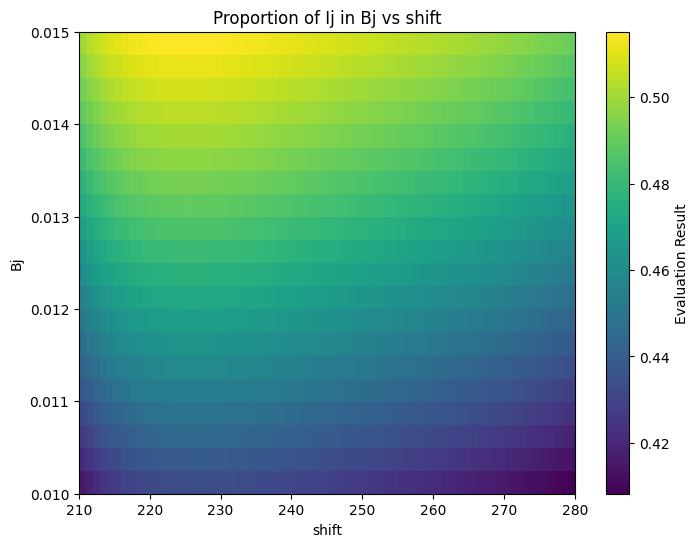

In [22]:
#EXAMPLE USAGE
param1_values = np.linspace(0.01, 0.015, 20)  # Create testing values for Bj
param2_values = np.linspace(210, 280, 70)  # Create testing values for Bf

# Initialize the model
model = Model()

# Initialize RasterModel with the parameters to raster
raster_model = RasterModel(model, 'Bj', 'shift', param1_values, param2_values)

# Run raster and plot heatmap
raster_model.raster()
raster_model.plot_heatmap()